<a href="https://colab.research.google.com/github/talhaanwarch/wound-segmentation/blob/master/FUSC_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#download data
!git clone https://github.com/talhaanwarch/wound-segmentation.git

Cloning into 'wound-segmentation'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 2599 (delta 6), reused 2 (delta 0), pack-reused 2584
Receiving objects: 100% (2599/2599), 256.16 MiB | 40.23 MiB/s, done.
Resolving deltas: 100% (938/938), done.
Checking out files: 100% (1621/1621), done.


In [2]:
%%capture
#install packages
!pip install -U segmentation-models

In [3]:
#import packages
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from tensorflow import keras
import numpy as np

Text(0.5, 1.0, 'Mask')

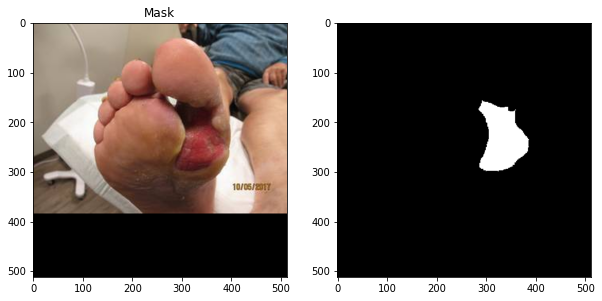

In [4]:
#explore data
image = Image.open('/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/0011.png')
mask=   Image.open('/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/0011.png')
fig,ax=plt.subplots(1,2,figsize=(10,15))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[0].set_title('Mask')

In [5]:
#get path of images and mask directories
train_image_path='/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/'
train_mask_path='/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/'

val_image_path='/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/'
val_mask_path='/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/'

In [6]:
#load paths of images and masks files
train_input_img_paths=[i for i in glob(train_image_path+'*.png')]
train_target_img_paths =[i for i in glob(train_mask_path+'*.png')]

val_input_img_paths=[i for i in glob(val_image_path+'*.png')]
val_target_img_paths =[i for i in glob(val_mask_path+'*.png')]
print(len(train_input_img_paths),len(val_input_img_paths))

610 200


In [7]:
#create a data loader 
#credit: https://keras.io/examples/vision/oxford_pets_image_segmentation/
class DataLoader(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = []
        for j, path in enumerate(batch_input_img_paths):
            img = Image.open(path)
            img = img.resize(img_size)
            img=np.array(img)
            x.append(img)
        x=np.array(x)
        if self.target_img_paths is not None:
          y = []
          for j, path in enumerate(batch_target_img_paths):
              img = Image.open(path).convert('L')
              img = img.resize(img_size)
              img=np.array(img)/255
              y.append(np.expand_dims(img, 2))
          y=np.array(y)
              
          return x, y
        else:
          return x

In [8]:
#create unet architecture
#credit: https://github.com/bnsreenu/python_for_microscopists/blob/master/208-simple_multi_unet_model.py

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda



################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [9]:
#parameters
img_size=(512, 512)
model = multi_unet_model(n_classes=1,IMG_HEIGHT=img_size[0], IMG_WIDTH=img_size[1],IMG_CHANNELS=3)
epochs=50
batch_size=24

In [10]:
#load data to data loader in batch
train_gen = DataLoader(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = DataLoader(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [11]:
#compile the model
model.compile(optimizer="rmsprop", loss="binary_crossentropy",metrics=keras.metrics.MeanIoU(num_classes=2))

In [12]:
#train the model
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/50
25/25 [==============================] - 70s 1s/step - loss: 17.8834 - mean_io_u: 0.4941 - val_loss: 0.1508 - val_mean_io_u: 0.4939
Epoch 2/50
25/25 [==============================] - 25s 1s/step - loss: 0.1945 - mean_io_u: 0.4933 - val_loss: 0.0776 - val_mean_io_u: 0.4939
Epoch 3/50
25/25 [==============================] - 25s 998ms/step - loss: 0.1139 - mean_io_u: 0.4932 - val_loss: 0.0739 - val_mean_io_u: 0.4939
Epoch 4/50
25/25 [==============================] - 25s 990ms/step - loss: 0.1010 - mean_io_u: 0.4930 - val_loss: 0.0781 - val_mean_io_u: 0.4939
Epoch 5/50
25/25 [==============================] - 25s 995ms/step - loss: 0.1342 - mean_io_u: 0.4939 - val_loss: 0.1296 - val_mean_io_u: 0.4939
Epoch 6/50
25/25 [==============================] - 25s 996ms/step - loss: 0.0796 - mean_io_u: 0.4936 - val_loss: 0.0621 - val_mean_io_u: 0.4939
Epoch 7/50
25/25 [==============================] - 25s 990ms/step - loss: 0.5329 - mean_io_u: 0.4933 - val_loss: 0.0704 - val_mean_io_

In [14]:
#get random image from val data and display the result
import random
test_img_number = random.randint(0, len(val_input_img_paths))
test_img = val_input_img_paths[test_img_number]
ground_truth=val_target_img_paths[test_img_number]
print(test_img)
print(ground_truth)

/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/0657.png
/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/0657.png


In [15]:
#resize image to be accepted by unet
test_img = Image.open(test_img)
test_img_resize =  test_img.resize(img_size)
print(test_img.size)
ground_truth = Image.open(ground_truth)

(512, 512)


(512, 512, 1)


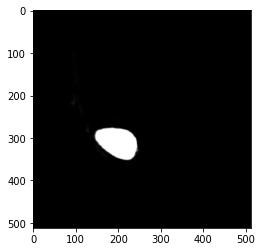

In [20]:
#Predict the output mask
test_img_input=np.expand_dims(test_img_resize, 0)
prediction = model.predict(test_img_input)[0,:,:,:]
print(prediction.shape)
plt.imshow(prediction.squeeze(),cmap='gray')

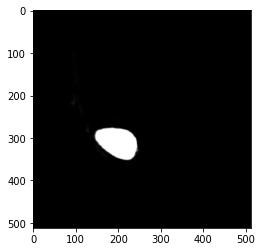

In [22]:
#resize image
from skimage.transform import resize
pred_resize=resize(prediction,(test_img.size[1],test_img.size[0]))
plt.imshow(pred_resize.squeeze(),cmap='gray')

Text(0.5, 1.0, 'Predicted Mask')

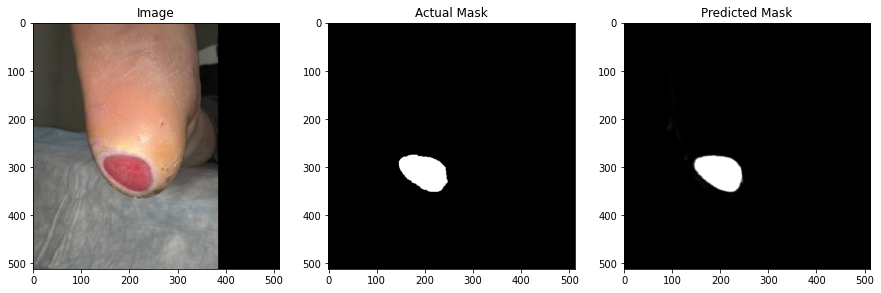

In [27]:
#display results
fig,ax=plt.subplots(1,3,figsize=(15,25))
ax[0].imshow(test_img)
ax[0].set_title('Image')
ax[1].imshow(ground_truth)
ax[1].set_title('Actual Mask')
ax[2].imshow(pred_resize.squeeze(),cmap='gray')
ax[2].set_title('Predicted Mask')